In [68]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split

In [79]:
class harmonic_oscillator:
    def __init__(self, k, mass, x0, u0):
        self.constant = -(k / mass)
        self.initial_conditions = np.array([x0, u0])

        #For analytical solutions
        self.A = np.sqrt(np.square(x0)+(np.square(u0)/(-self.constant)))
        self.phi = np.arcsin(x0/self.A)
        self.omega = np.sqrt(-self.constant)
        self.period = 2*np.pi/self.omega
        self.energy = None

        #For saving data
        self.generated_points = None
        self.sampled_points = None
        self.dt_used_for_generation = None 
        self.t_final_used_for_generation = None 
        self.all_gradients = None 
    def calculate_coord_analyticaly(self, t):
        x = self.A * np.sin(self.omega*t+self.phi)
        u = self.A*self.omega* np.cos(self.omega*t+self.phi)
        return x, u
    def calculate_accelaration(self, x):
        return self.constant*x 
    def calculate_derivative(self, x, u):
        accelaration = self.calculate_accelaration(x)
        return np.array([u, accelaration])
    def move_interval(self, x, u, dt):
        step = self.calculate_derivative(x, u)*dt
        return np.array([x, u]) + step
    def generate_points(self, t_final, dt, analyticaly=False, save=False):
            points = []
            if t_final=='period':
                t_final=self.period
            time_points = np.arange(0, t_final + dt, dt) # This array now starts at 0

            if analyticaly==False:
                current_position = self.initial_conditions
                for time in time_points: # Iterate through the proper time points
                    points.append(np.array([current_position[0], current_position[1], time]))
                    current_position = self.move_interval(current_position[0], current_position[1], dt)
            else: # analyticaly==True
                for time in time_points: # Iterate through the proper time points
                    x, u = self.calculate_coord_analyticaly(time)
                    points.append(np.array([x, u, time]))
            
            if save == True:
                self.generated_points = points
                self.dt_used_for_generation = dt 
                self.t_final_used_for_generation = t_final
            return points
    def sample_points(self, sample_ratio, n_segments, random_segments=False, save=True):
        num_points = len(self.generated_points)
        num_samples_overall = int(num_points * sample_ratio)

        if n_segments <= 0:
            raise ValueError("n_segments must be a positive integer.")
        if num_samples_overall == 0:
            return []
        
        num_samples_per_segment = num_samples_overall // n_segments
        if num_samples_per_segment == 0:
            print(f"Warning: With {num_points} points, {sample_ratio} ratio, and {n_segments} segments, you'll get less than 1 sample per segment. Adjusting to sample 1 point from {num_samples_overall} segments.")
            num_samples_per_segment = 1
            n_segments = min(n_segments, num_samples_overall) # Adjust n_segments to actual samples

        segment_length = num_points // n_segments
        
        # Ensure we don't try to sample more points than available in a segment
        if num_samples_per_segment > segment_length:
            raise ValueError(f"num_samples_per_segment ({num_samples_per_segment}) is greater than "
                             f"the segment length ({segment_length}). Adjust sample_ratio or n_segments.")

        sampled_points = []
        
        if random_segments:
            for i in range(n_segments):
                # Define the bounds for choosing a center for this specific conceptual segment
                start_boundary = i * (num_points // n_segments)
                end_boundary = (i + 1) * (num_points // n_segments)
                
                # Adjust end_boundary for the last segment
                if i == n_segments - 1:
                    end_boundary = num_points


                
                valid_min_start_index = start_boundary
                valid_max_start_index = end_boundary - num_samples_per_segment
                
                if valid_min_start_index > valid_max_start_index:
                    # This segment is too small to fit the desired number of samples
                    # print(f"Warning: Segment {i} cannot fit {num_samples_per_segment} samples. Skipping or taking what's available.")
                    if end_boundary - start_boundary > 0:
                        # Take as many as possible if the segment has points
                        num_to_take = min(num_samples_per_segment, end_boundary - start_boundary)
                        start_idx = random.randint(start_boundary, end_boundary - num_to_take)
                        sampled_points.extend(self.generated_points[start_idx : start_idx + num_to_take])
                    continue # Skip to next segment

                random_start_index = random.randint(valid_min_start_index, valid_max_start_index)
                
                # Add points to the list
                sampled_points.extend(self.generated_points[random_start_index : random_start_index + num_samples_per_segment])

        else: # Equally separated segments
            step_between_segments = num_points // n_segments
            
            # Calculate the effective sample size to prevent index errors
            # if num_samples_per_segment is large relative to step_between_segments
            effective_sample_size = min(num_samples_per_segment, step_between_segments)

            for i in range(n_segments):
                segment_start_index = i * step_between_segments
                
                # Ensure we don't go out of bounds when taking consecutive points
                # The end index should not exceed num_points
                end_index_for_segment = min(segment_start_index + effective_sample_size, num_points)
                
                # If a segment is empty due to rounding, skip
                if segment_start_index >= end_index_for_segment:
                    continue

                sampled_points.extend(self.generated_points[segment_start_index : end_index_for_segment])
        

        if save==True:
            self.sampled_points=sampled_points[:num_samples_overall]
        return sampled_points[:num_samples_overall]


    def calculate_all_gradients(self, save=True):
        if self.generated_points is None:
            raise ValueError("No points generated yet. Call 'generate_points' first.")
        
        gradients = []
        for point in self.generated_points:
            x, u = point[0], point[1]
            gradient_vector = self.calculate_derivative(x, u)
            gradients.append(gradient_vector)
        
        if save:
            self.all_gradients = np.array(gradients)
        return np.array(gradients)
    




    def plot_points(self, show_sampled=False, show_derivative=False, show_generated=True):
        """
        Plot phase space trajectory (velocity vs position).
        
        Parameters:
        show_sampled: bool - If True, plot sampled points in a different color.
        show_derivative: bool - If True, plot gradient arrows at generated points.
        show_generated: bool - If True, plot all generated points.
        """
        if self.generated_points is None:
            raise ValueError("No points have been generated yet. Call 'generate_points' first.")
        
        # Retrieve dt and t_final from saved attributes
        dt = self.dt_used_for_generation
        t_final = self.t_final_used_for_generation

        # Convert generated_points to numpy array for easier handling
        gen_points_np = np.array(self.generated_points)
        x_gen = gen_points_np[:, 0]
        u_gen = gen_points_np[:, 1]
        time_gen = gen_points_np[:, 2]

        plt.figure(figsize=(10, 8))
        
        # Plot generated points if requested
        if show_generated:
            plt.plot(x_gen, u_gen, 'b-', linewidth=1.5, alpha=0.7, label='Generated Trajectory')
            # Changed from scatter to plot to remove time-based coloring by default
            plt.plot(x_gen, u_gen, 'bo', markersize=3, alpha=0.4, label='Generated Points') 
            
            # Highlight initial point
            plt.scatter(x_gen[0], u_gen[0], color='red', s=100, zorder=5, label=f'Initial point (t={time_gen[0]:.3f})')
            plt.annotate(f't = {time_gen[0]:.3f}', xy=(x_gen[0], u_gen[0]), xytext=(10, 10), textcoords='offset points',bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),fontsize=10, color='white', weight='bold')
            
            # Highlight final point
            # Adjusting t_final_label for consistency with arange. 
            # If you modified generate_points to include t_final, this should be t_final.
            plt.scatter(x_gen[-1], u_gen[-1], color='orange', s=100, zorder=5, label=f'Final point (t={time_gen[-1]:.3f})') # <-- CHANGE HERE (use time_gen[-1])
            plt.annotate(f't = {time_gen[-1]:.3f}', xy=(x_gen[-1], u_gen[-1]), xytext=(-10, -20), textcoords='offset points',bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),fontsize=10, color='white', weight='bold')
            
            # Add dt information as text box (if generated points are shown)
            plt.text(0.02, 0.98, f'dt = {dt}', transform=plt.gca().transAxes,bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),fontsize=11, verticalalignment='top')
            
            # Remove colorbar for time for generated points as requested.

        # Plot sampled points if requested
        if show_sampled:
            if self.sampled_points is None:
                raise ValueError("No points have been sampled yet. Call 'sample_points' first or ensure 'save=True'.")
            
            sampled_points_np = np.array(self.sampled_points)
            x_sampled = sampled_points_np[:, 0]
            u_sampled = sampled_points_np[:, 1]
            plt.scatter(x_sampled, u_sampled, color='red', marker='x', s=50, zorder=3, label='Sampled Points')

        # Plot derivatives (quiver plot) if requested
        if show_derivative:
            if self.all_gradients is None:
                raise ValueError("No gradients have been calculated yet. Call 'calculate_all_gradients' first or ensure 'save=True'.")
            
            gradients_np = self.all_gradients
            
            # The u and v components for quiver are the derivative values
            # u_vec is dx/dt (velocity), v_vec is du/dt (acceleration)
            u_vec = gradients_np[:, 0] 
            v_vec = gradients_np[:, 1]
            
            # Calculate magnitude for coloring
            magnitudes = np.sqrt(u_vec**2 + v_vec**2)
            
            # Use plt.quiver to plot arrows
            # scale_units='xy' and scale=1 makes arrows represent the actual magnitude in data units
            # angles='xy' ensures arrows point correctly in data coordinates
            quiv = plt.quiver(x_gen, u_gen, u_vec, v_vec, magnitudes, 
                              cmap='viridis', scale_units='xy', scale=None, alpha=0.7,
                              headwidth=4, headlength=6, pivot='middle', label='Gradients (Velocity, Acceleration)')
            plt.colorbar(quiv, label='Gradient Magnitude')


        plt.xlabel('Position (x)', fontsize=12)
        plt.ylabel('Velocity (u)', fontsize=12)
        plt.title(f'Phase Space Plot - Harmonic Oscillator', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()





        
class PhaseSpace:
    def __init__(self, k, mass):
        self.oscillators = []
        self.k = k
        self.mass = mass
        self.max_x0_param = None 
        self.max_u0_param = None 
        self.n_oscillators = None


        self.dt_used_for_phase_space_generation = None 
        self.t_final_used_for_phase_space_generation = None 

    def make_oscillators(self, n_oscillators, max_x0, max_u0, method):
        self.oscillators = [] # Clear existing oscillators if called multiple times
        self.n_oscillators = n_oscillators
        self.max_x0_param = max_x0
        self.max_u0_param = max_u0

        if method == 'fully_random':
            for i in range(n_oscillators):
                # x0 can be positive or negative
                random_x0 = np.random.uniform(-max_x0, max_x0) 
                # u0 can be positive or negative
                random_u0 = np.random.uniform(-max_u0, max_u0)
                new_oscillator = harmonic_oscillator(k=self.k, mass=self.mass, x0=random_x0, u0=random_u0)
                self.oscillators.append(new_oscillator)

        elif method == 'random_energies':
            # Max energy defined by the corners of the phase space box
            max_energy_corner1 = 0.5 * (self.mass * (max_u0**2) + self.k * (max_x0**2))
            # Max energy considering only u0 (x0=0) or only x0 (u0=0)
            max_energy_u = 0.5 * self.mass * (max_u0**2)
            max_energy_x = 0.5 * self.k * (max_x0**2)
            max_energy = max(max_energy_corner1, max_energy_u, max_energy_x)

            for i in range(n_oscillators):
                random_energy = np.random.uniform(0.001, max_energy) # Ensure positive energy
                
                # For a given energy E, x must be within [-sqrt(2E/k), sqrt(2E/k)]
                x_limit_for_energy = np.sqrt(2 * random_energy / self.k)
                # Cap x0 to max_x0 parameter given
                actual_x0_limit = min(max_x0, x_limit_for_energy)

                # Randomly choose x0 within the allowed range for this energy AND max_x0
                random_x0 = np.random.uniform(-actual_x0_limit, actual_x0_limit)
                
                # Calculate u0 (can be positive or negative)
                # u^2 = (2E - kx^2) / m
                u_squared = (2 * random_energy - (self.k * (random_x0**2))) / self.mass
                
                # Ensure u_squared is not negative due to floating point inaccuracies
                u_squared = max(0, u_squared) 

                derived_u0_magnitude = np.sqrt(u_squared)
                
                # Randomly assign sign to u0
                derived_u0 = derived_u0_magnitude * np.random.choice([-1, 1])
                
                # Cap u0 to max_u0 parameter given
                if abs(derived_u0) > max_u0:
                    derived_u0 = np.sign(derived_u0) * max_u0

                new_oscillator = harmonic_oscillator(k=self.k, mass=self.mass, x0=random_x0, u0=derived_u0)
                self.oscillators.append(new_oscillator)

        elif method == 'stratified_energies':
            max_energy = 0.5 * (self.mass * (max_u0**2) + self.k * (max_x0**2))
            energy_min = 0.001 
            energy_interval = (max_energy - energy_min) / n_oscillators
            
            for i in range(n_oscillators):
                current_energy = energy_min + i * energy_interval
                
                x_limit_for_energy = np.sqrt(2 * current_energy / self.k)
                actual_x0_limit = min(max_x0, x_limit_for_energy)

                random_x0 = np.random.uniform(-actual_x0_limit, actual_x0_limit)
                
                u_squared = (2 * current_energy - (self.k * (random_x0**2))) / self.mass
                u_squared = max(0, u_squared)

                derived_u0_magnitude = np.sqrt(u_squared)
                derived_u0 = derived_u0_magnitude * np.random.choice([-1, 1])
                
                new_oscillator = harmonic_oscillator(k=self.k, mass=self.mass, x0=random_x0, u0=derived_u0)
                new_oscillator.energy = current_energy
                self.oscillators.append(new_oscillator)
        else:
            raise ValueError("Method must be 'fully_random', 'random_energies', or 'stratified_energies'.")
        
    def generate_all_oscillators_points(self, t_final, dt, analyticaly=False):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")

        n_generated_points = 0
        for osc in self.oscillators:
            # Each oscillator generates and saves its own points
            osc.generate_points(t_final=t_final, dt=dt, analyticaly=analyticaly, save=True)
            n_generated_points += len(osc.generated_points)
        
        if t_final=='period':
            t_final=self.oscillators[0].period

        self.dt_used_for_phase_space_generation = dt
        self.t_final_used_for_phase_space_generation = t_final
        print(f"Generated a total of {n_generated_points} points")
        return None

    def calculate_all_oscillators_gradients(self):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        
        if self.oscillators[0].generated_points is None:
            raise ValueError("No generated points for oscillators. Call 'generate_all_oscillators_points' first.")

        for osc in self.oscillators:
            osc.calculate_all_gradients(save=True) 
        
        return None
    
    def sample_all_oscillators_points(self, sample_ratio, n_segments, random_segments=False):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        

        if self.oscillators[0].generated_points is None:
            raise ValueError("Generated points for all oscillators not found. Call 'generate_all_oscillators_points' first.")

        for osc in self.oscillators:
            osc.sample_points(sample_ratio=sample_ratio, n_segments=n_segments, random_segments=random_segments, save=True) 

        return None
    
    def make_trajectories_ids_df(self):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        

        if self.oscillators[0].generated_points is None:
            raise ValueError("Generated points for all oscillators not found. Call 'generate_all_oscillators_points' first.")
        
        data = []
        start_index = np.int64(0)
        for i, osc in enumerate(self.oscillators):
            x0, u0 = osc.initial_conditions  # unpack np.array([x0, u0])
            energy = osc.energy
            number_of_points = np.int64(len(osc.generated_points))
            data.append({"trajectory_id":i, "x0": x0, "u0": u0, "energy": energy, "generated_points": np.int64(number_of_points), "start_index":np.int64(start_index), "end_index":start_index+number_of_points})
            start_index += number_of_points
        df = pd.DataFrame(data)
        df = df.astype({"generated_points": "int64", "start_index": "int64", "end_index": "int64"})
        return df


    def make_trajectories_df(self):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        

        if self.oscillators[0].generated_points is None:
            raise ValueError("Generated points for all oscillators not found. Call 'generate_all_oscillators_points' first.")
        
        data = []

        for osc in self.oscillators:
            for point in osc.generated_points:
                data.append({"x": point[0], "u": point[1], "t": point[2]})
        df = pd.DataFrame(data)
        return df


    def plot_phase_space(self, show_sampled=False, show_derivative=False, show_generated=True, plot_limits=None):
        """
        Plots the phase space of all oscillators.
        
        Parameters:
        show_sampled: bool - If True, plots the sampled points.
        show_derivative: bool - If True, plots the gradient arrows.
        show_generated: bool - If True, plots all generated points/trajectories.
        plot_limits: tuple or None - (xmin, xmax, ymin, ymax) to set explicit plot limits.
        """
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        
        plt.figure(figsize=(10, 8))

        # Retrieve dt and t_final from saved attributes for plot title
        dt = self.dt_used_for_phase_space_generation
        t_final = self.t_final_used_for_phase_space_generation

        # Plot generated points/trajectories
        if show_generated:
            if self.oscillators[0].generated_points is None:
                raise ValueError("No points generated for all oscillators. Call 'generate_all_oscillators_points' first.")
            
            all_initial_x = []
            all_initial_u = []



            for i, osc in enumerate(self.oscillators):
                gen_points_np = np.array(osc.generated_points)
                x_gen = gen_points_np[:, 0]
                u_gen = gen_points_np[:, 1]
                
                plt.plot(x_gen, u_gen, alpha=0.6, linewidth=0.8, color='blue', label=f'Oscillator {i+1} Trajectory' if len(self.oscillators) <= 5 else "_nolegend_")
                all_initial_x.append(x_gen[0])
                all_initial_u.append(u_gen[0])
            
            # Plot all initial points together for clarity, regardless of n_oscillators
            plt.scatter(all_initial_x, all_initial_u, color='red', marker='o', s=20, alpha=0.6, label='Initial Conditions')
            
            # Add a single label for the trajectories if there are many
            if self.n_oscillators > 5:
                plt.plot([], [], 'b-', alpha=0.6, linewidth=0.8, label='Trajectories')


        # Plot sampled points
        if show_sampled:
            # Check if at least one oscillator has sampled points
            if self.oscillators[0].sampled_points is None:
                raise ValueError("No points sampled for oscillators. Call 'sample_all_oscillators_points' first.")
            
            all_sampled_x = []
            all_sampled_u = []
            for osc in self.oscillators:
                if osc.sampled_points is not None: # Only add if this oscillator has sampled points
                    sampled_points_np = np.array(osc.sampled_points)
                    all_sampled_x.extend(sampled_points_np[:, 0])
                    all_sampled_u.extend(sampled_points_np[:, 1])
            
            if all_sampled_x: # Only plot if there are actual sampled points
                plt.scatter(all_sampled_x, all_sampled_u, color='purple', marker='x', s=50, zorder=3, label='Sampled Points')

        # Plot derivatives (quiver plot)
        if show_derivative:
            # Check if at least one oscillator has gradients calculated
            if self.oscillators[0].all_gradients is None:
                raise ValueError("No gradients calculated for oscillators. Call 'calculate_all_oscillators_gradients' first.")
            
            all_quiver_x = []
            all_quiver_u = []
            all_u_vec = []
            all_v_vec = []

            for osc in self.oscillators:
                if osc.all_gradients is not None and osc.generated_points is not None:
                    gen_points_np = np.array(osc.generated_points)
                    gradients_np = osc.all_gradients # Assumed to be numpy array already from osc.calculate_all_gradients

                    all_quiver_x.extend(gen_points_np[:, 0])
                    all_quiver_u.extend(gen_points_np[:, 1])
                    all_u_vec.extend(gradients_np[:, 0])
                    all_v_vec.extend(gradients_np[:, 1])
            
            if all_quiver_x: # Only plot if there are actual gradients
                all_quiver_x_np = np.array(all_quiver_x)
                all_quiver_u_np = np.array(all_quiver_u)
                all_u_vec_np = np.array(all_u_vec)
                all_v_vec_np = np.array(all_v_vec)

                magnitudes = np.sqrt(all_u_vec_np**2 + all_v_vec_np**2)
                
                quiv = plt.quiver(all_quiver_x_np, all_quiver_u_np, all_u_vec_np, all_v_vec_np, magnitudes, 
                                  cmap='viridis', scale_units='xy', scale=None, alpha=0.7,
                                  headwidth=4, headlength=6, pivot='middle', label='Gradients')
                plt.colorbar(quiv, label='Gradient Magnitude')

        plt.xlabel('Position (x)', fontsize=12)
        plt.ylabel('Velocity (u)', fontsize=12)
        
        title_suffix = ""
        if dt is not None and t_final is not None:
            title_suffix = f" (t_final={t_final}, dt={dt})"
        plt.title(f'Phase Space of {self.n_oscillators} Harmonic Oscillators{title_suffix}', fontsize=14)
        
        plt.grid(True, alpha=0.3)
        plt.legend()

        if plot_limits:
            plt.xlim(plot_limits[0], plot_limits[1])
            plt.ylim(plot_limits[2], plot_limits[3])
        elif self.max_x0_param is not None and self.max_u0_param is not None:
             # Use the max_x0, max_u0 used to make oscillators with a slightly larger buffer
             plt.xlim(-self.max_x0_param * 1.5, self.max_x0_param * 1.5)
             plt.ylim(-self.max_u0_param * 1.5, self.max_u0_param * 1.5)

        plt.tight_layout()
        plt.show()
        
    
    


In [80]:
Phase = PhaseSpace(k=1, mass=1)

In [81]:
Phase.make_oscillators(n_oscillators=10, max_x0=10, max_u0=10, method='stratified_energies')

In [82]:
Phase.generate_all_oscillators_points(t_final='period', dt=0.1, analyticaly=True)

Generated a total of 640 points


In [83]:
df = Phase.make_trajectories_ids_df()

In [84]:
df_1 = Phase.make_trajectories_df()

In [85]:
len(Phase.oscillators[1].generated_points)

64

In [86]:
df_1.iloc[df.loc[1, 'start_index']:df.loc[1, 'end_index']]

,x,u,t
64,-0.415745,4.452972,0.0
65,0.030888,4.472231,0.1
66,0.477211,4.446804,0.2
67,0.918767,4.376947,0.3
68,1.351143,4.263357,0.4
...,...,...,...
123,-2.050457,3.974598,5.9
124,-1.643415,4.159445,6.0
125,-1.219953,4.302733,6.1
126,-0.784302,4.403030,6.2


In [ ]:

def split_trajectories(ids_df, full_df, val_pct=0.1, test_pct=0.1, random_state=42, bins=10):
    """
    Split oscillator trajectories into train/val/test sets, stratified by energy.

    Args:
        ids_df (pd.DataFrame): Output of make_trajectories_ids_df (one row per oscillator).
        full_df (pd.DataFrame): Output of make_trajectories_df (all trajectory points).
        val_pct (float): Fraction of oscillators to use for validation.
        test_pct (float): Fraction of oscillators to use for test.
        random_state (int): Random seed for reproducibility.
        bins (int): Number of bins to discretize energy for stratification.

    Returns:
        (train_df, val_df, test_df,
         train_id_df, val_id_df, test_id_df)
    """
    # copy to avoid modifying original
    ids_df = ids_df.copy()
    ids_df["energy_bin"] = pd.qcut(ids_df["energy"], q=bins, duplicates="drop")

    # split test first
    train_val_ids, test_id_df = train_test_split(
        ids_df,
        test_size=test_pct,
        stratify=ids_df["energy_bin"],
        random_state=random_state
    )

    # then split val from remaining
    train_id_df, val_id_df = train_test_split(
        train_val_ids,
        test_size=val_pct / (1 - test_pct),  # adjust relative size
        stratify=train_val_ids["energy_bin"],
        random_state=random_state
    )

    # clean up temporary column
    for df in (train_id_df, val_id_df, test_id_df):
        df.drop(columns=["energy_bin"], inplace=True)

    # --- build point-level splits ---
    def gather_points(sub_ids):
        mask = pd.Series(False, index=full_df.index)
        for _, row in sub_ids.iterrows():
            mask.loc[row["start_index"]:row["end_index"]-1] = True
        return full_df[mask]

    train_df = gather_points(train_id_df)
    val_df   = gather_points(val_id_df)
    test_df  = gather_points(test_id_df)

    return train_df, val_df, test_df, train_id_df, val_id_df, test_id_df


In [90]:
df.columns

Index(['trajectory_id', 'x0', 'u0', 'energy', 'generated_points',
       'start_index', 'end_index'],
      dtype='object')

In [110]:
train_df, val_df, test_df, train_id_df, val_id_df, test_id_df = split_trajectories(ids_df=df, full_df=df_1, val_pct=0.3, test_pct=0.1, random_state=42, bins=1)

In [111]:
train_id_df

,trajectory_id,x0,u0,energy,generated_points,start_index,end_index
8,8,7.876724,-9.897354,80.0002,64,512,576
1,1,-0.415745,4.452972,10.0009,64,64,128
9,9,7.816047,10.904568,90.0001,64,576,640
5,5,6.755665,-7.373058,50.0005,64,320,384
2,2,-0.219258,6.320880,20.0008,64,128,192
4,4,3.774571,-8.108873,40.0006,64,256,320


In [117]:
val_id_df

,trajectory_id,x0,u0,energy,generated_points,start_index,end_index
7,7,6.661686,-9.778678,70.0003,64,448,512
0,0,-0.019225,0.040378,0.0010,64,0,64
3,3,5.668276,5.279398,30.0007,64,192,256


In [113]:
test_id_df

,trajectory_id,x0,u0,energy,generated_points,start_index,end_index
6,6,-2.998581,-10.536096,60.0004,64,384,448


In [107]:
df_1

,x,u,t
0,-0.019225,0.040378,0.0
1,-0.015098,0.042096,0.1
2,-0.010820,0.043393,0.2
3,-0.006434,0.044256,0.3
4,-0.001983,0.044677,0.4
...,...,...,...
635,3.172251,13.035990,5.9
636,4.457830,12.654167,6.0
637,5.698869,12.145909,6.1
638,6.882966,11.516292,6.2


In [100]:
train_df

,x,u,t
64,-0.415745,4.452972,0.0
65,0.030888,4.472231,0.1
66,0.477211,4.446804,0.2
67,0.918767,4.376947,0.3
68,1.351143,4.263357,0.4
...,...,...,...
635,3.172251,13.035990,5.9
636,4.457830,12.654167,6.0
637,5.698869,12.145909,6.1
638,6.882966,11.516292,6.2


In [121]:
val_df.loc[500]

x    -5.517907
u    10.466771
t     5.200000
Name: 500, dtype: float64

In [102]:
test_df

,x,u,t
192,5.668276,5.279398,0.0
193,6.167019,4.687140,0.1
194,6.604142,4.048049,0.2
195,6.975280,3.368512,0.3
196,7.276722,2.655317,0.4
...,...,...,...
443,-6.720320,8.650902,5.9
444,-5.823097,9.278596,6.0
445,-4.867692,9.813581,6.1
446,-3.863650,10.250512,6.2


In [47]:
Phase.sample_all_oscillators_points(sample_ratio=0.6, n_segments=10, random_segments=True)

In [48]:
Phase.calculate_all_oscillators_gradients()

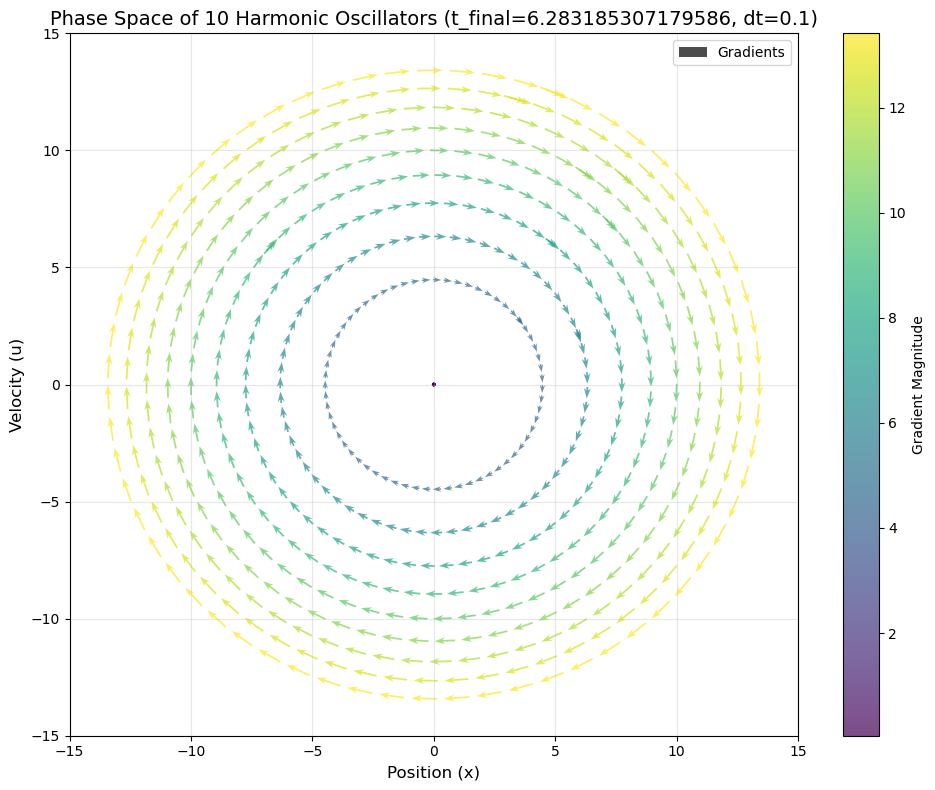

In [9]:
Phase.plot_phase_space(show_sampled=False, show_derivative=True, show_generated=False, plot_limits=None)

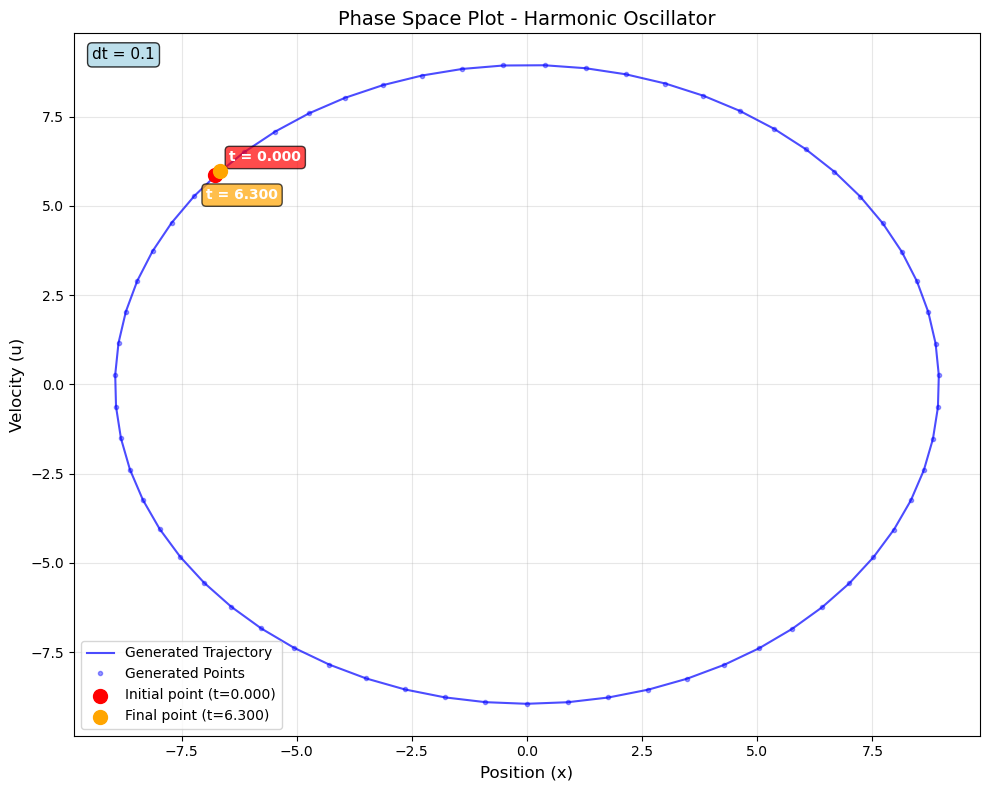

In [10]:
Phase.oscillators[4].plot_points(show_sampled=False, show_derivative=False, show_generated=True)

In [13]:
points_per_trajectory_number_of_different_trajectories_ratio = 2
samples_per_period = 60
periods_per_trajectory = 4
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega
dt = period/samples_per_period
Tmax = periods_per_trajectory*period
points_per_trajectory = int(Tmax/dt)
n_tajectories = int(points_per_trajectory/points_per_trajectory_number_of_different_trajectories_ratio)
total_points = n_tajectories*points_per_trajectory


In [14]:
n_tajectories

120

In [15]:
points_per_trajectory

240

In [16]:
total_points

28800

In [17]:
max_x0=11
max_u0=11
max_energy = 0.5 * (mass * (max_u0**2) + k * (max_x0**2))
max_energy

121.0